### Load Dependencies

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from keras.layers.wrappers import Bidirectional 
from keras.layers import Conv1D, MaxPooling1D 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

### Set Hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/cnnLSTM'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# convolutional layer architecture:
n_conv = 64  
k_conv = 3 
mp_size = 4

# LSTM layer architecture:
n_lstm = 64 
drop_lstm = 0.2

### Load Data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

### Preprocess Data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

### Design Neural Network Architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(MaxPooling1D(mp_size))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [6]:
# LSTM layer parameters double due to both reading directions
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 718,529
Trainable params: 718,529
Non-trainable params: 0
__________________________________________________

### Configure the Model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train the Model

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 106s 540ms/step - loss: 0.4479 - accuracy: 0.7650 - val_loss: 0.3043 - val_accuracy: 0.8712
Epoch 2/4
196/196 [==============================] - 81s 412ms/step - loss: 0.2296 - accuracy: 0.9096 - val_loss: 0.3118 - val_accuracy: 0.8711
Epoch 3/4
196/196 [==============================] - 78s 396ms/step - loss: 0.1624 - accuracy: 0.9426 - val_loss: 0.3566 - val_accuracy: 0.8604
Epoch 4/4
196/196 [==============================] - 78s 397ms/step - loss: 0.1224 - accuracy: 0.9577 - val_loss: 0.4373 - val_accuracy: 0.8553


### Evaluate the Model

In [10]:
model.load_weights(output_dir+"/weights.02.hdf5") 

In [11]:
y_hat = model.predict_proba(x_valid)

Instructions for updating:
Please use `model.predict()` instead.


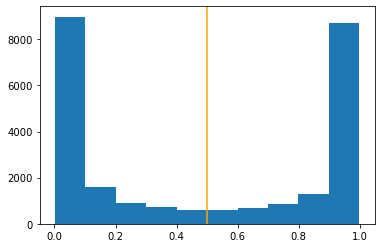

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'94.45'